In [1]:
import glob
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:

pathToImagesVal = '/content/drive/MyDrive/ISP/Orignal_Data_Set/Orignal_Image_Data/*.png'
pathToMapsVal = '/content/drive/MyDrive/ISP/Orignal_Data_Set/Orignal_Label_Data/*.png'

pathToResizedImagesVal = '/content/drive/MyDrive/ISP/Preprocessed_Dataset/images/'
pathToResizedMapsVal = '/content/drive/MyDrive/ISP/Preprocessed_Dataset/labels/'

In [4]:
INPUT_SIZE = (256, 192)

In [6]:
list_img_files = sorted(glob.glob(pathToImagesVal))

In [ ]:
list_img_files

In [8]:
len(list_img_files)

199

In [12]:
list_val_img_files = sorted(glob.glob(pathToImagesVal))
list_val_map_files = sorted(glob.glob(pathToMapsVal))

for curr_file in range(len(list_val_img_files)):

    imageResized = cv2.resize(cv2.imread(list_val_img_files[curr_file]), INPUT_SIZE, interpolation=cv2.INTER_AREA)
    mapResized = cv2.resize(cv2.imread(list_val_map_files[curr_file]), INPUT_SIZE, interpolation=cv2.INTER_AREA)
        
    cv2.imwrite(pathToResizedImagesVal + (os.path.basename(list_val_img_files[curr_file])), imageResized)
    cv2.imwrite(pathToResizedMapsVal + (os.path.basename(list_val_map_files[curr_file])), mapResized)


print('Done resizing val images and Maps.....')

Done resizing val images and Maps.....


In [ ]:
###################### Prediciton #############################

In [13]:

import tensorflow as tf
from tensorflow import keras

In [14]:
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
%matplotlib inline

In [15]:
from PIL import Image

In [16]:
from PIL import Image

In [17]:
import torch.nn as nn

def conv2d(in_channels, out_channels, kernel_size = 3, padding = 1):
    return nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, padding = padding)

def deconv2d(in_channels, out_channels, kernel_size = 3, padding = 1):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, padding = padding)

def relu(inplace = True): # Change to True?
    return nn.ReLU(inplace)

def maxpool2d():
    return nn.MaxPool2d(2)

In [18]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import math
from torch.autograd import Variable

def make_conv_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [maxpool2d()]
        else:
            conv = conv2d(in_channels, v)
            layers += [conv, relu(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


def make_deconv_layers(cfg):
    layers = []
    in_channels = 512
    for v in cfg:
        if v == 'U':
            layers += [nn.Upsample(scale_factor=2)]
        else:
            deconv = deconv2d(in_channels, v)
            layers += [deconv]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512],
    'D': [512, 512, 512, 'U', 512, 512, 512, 'U', 256, 256, 256, 'U', 128, 128, 'U', 64, 64]
}

def encoder():
    return make_conv_layers(cfg['E'])

def decoder():
    return make_deconv_layers(cfg['D'])

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
        self.mymodules = nn.ModuleList([
            deconv2d(64,1,kernel_size=1, padding = 0),
            nn.Sigmoid()
        ])

    def forward(self,x): #
        #print('Input x', x.size())
        x = self.encoder(x)
        #print('After encoder = ', x.size())
        x = self.decoder(x)
        #print('After decoder = ', x.size())
        x = self.mymodules[0](x)
        x = self.mymodules[1](x)
        #print('Final size = ', x.size())
        return x

In [19]:
import torch.nn as nn
import torch
import math
from torch.autograd import Variable

#os.environ['CUDA_VISIBLE_DEVICES'] = '2'

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.convs = nn.Sequential( # [-1, 4, 256,192]
                conv2d(4,3,kernel_size=1),
                relu(),
                conv2d(3,32,kernel_size=3), #[-1, 32, 256, 192]
                relu(),
                maxpool2d(),
                conv2d(32,64,kernel_size=3), #[-1, 64, 128, 96]
                relu(),
                conv2d(64,64,kernel_size=3), #[-1, 64, 128, 96]
                relu(),
                maxpool2d(), #[-1,64,64,48]
                conv2d(64,64,kernel_size=3), #[-1,64,64,48]
                relu(),
                conv2d(64,64,kernel_size=3),
                relu(),
                maxpool2d(), #[-1,64,32,24]
        )
        self.mymodules = nn.ModuleList([
            nn.Sequential(nn.Linear(64*32*24, 100), nn.Tanh()),
            nn.Sequential(nn.Linear(100,2), nn.Tanh()),
            nn.Sequential(nn.Linear(2,1), nn.Sigmoid())
        ])
        #self._initialize_weights()

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.mymodules[0](x)
        x = self.mymodules[1](x)
        x = self.mymodules[2](x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #print(m.weight.data.shape)
                #print('old conv2d layer!')
                #print(m.weight.data.min())
                #print(m.weight.data.max())
                m.weight.data.normal_(0, math.sqrt(2. / n))
                #print('new conv2d layer!')
                #print(m.weight.data.min())
                #print(m.weight.data.max())
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [32]:
def to_variable(x,requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x,requires_grad)

def show(img): # Display rgb tensor image
    pilTrans = transforms.ToPILImage()
    pilImg = pilTrans(img)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)
    
def show_gray(img): # Display grayscale tensor image
    pilTrans = transforms.ToPILImage()
    pilImg = pilTrans(img)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)
    
def show_img_from_path(imgPath):
    pilImg = Image.open(imgPath)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)
    
def predict(model, img):
    to_tensor = transforms.ToTensor() # Transforms 0-255 numbers to 0 - 1.0.
    im = to_tensor(img)
    inp = to_variable(im.unsqueeze(0), False)
    out = model(inp)
    map_out = out.cpu().data.squeeze(0)
    return map_out


In [26]:
list_img = [k.split('/')[-1].split('.')[0] for k in sorted(glob.glob(pathToResizedImagesVal+'*.png'))]

In [39]:
list_pred_img = sorted(glob.glob(pathToResizedImagesVal+'*.png'))


In [ ]:
list_pred_img

In [37]:
PathToPredictions = '/content/drive/MyDrive/ISP/predictions_IVP_data/'

In [64]:
list_org_mps = sorted(glob.glob(pathToResizedMapsVal+'*.png'))

In [ ]:
print(PathToPredictions + list_img[120] + '.png' )

In [130]:
img = cv2.imread(list_pred_img[7])

In [47]:
from google.colab.patches import cv2_imshow

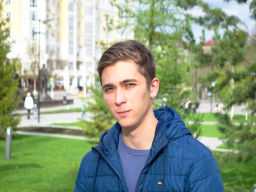

In [131]:
cv2_imshow(img)

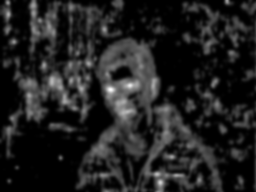

In [132]:

img = cv2.imread(list_org_mps[7])
cv2_imshow(img)

In [133]:
model = Generator()
pretrained_dict = torch.load('/content/drive/MyDrive/ISP/Improved_with_100_epochs/Improved_with_100_epochs/generator.h5', map_location=torch.device('cpu'))
model.load_state_dict(pretrained_dict)

img = cv2.imread(list_pred_img[7])
sal_predicted = predict(model,img)

In [136]:
sal_predicted = np.asarray(sal_predicted)

In [137]:
norm_image = cv2.normalize(sal_predicted[0,:,:], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

norm_image = norm_image.astype(np.uint8)

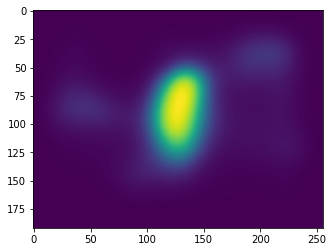

In [138]:
plt.imshow(norm_image)

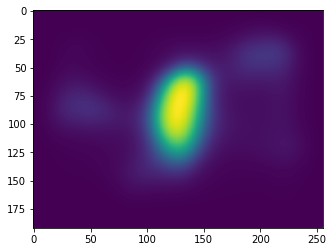

In [134]:
plt.imshow(sal_predicted[0,:,:])

In [139]:
sal_predicted

for i in range(len(list_pred_img)):
  model = Generator()
  pretrained_dict = torch.load('/content/drive/MyDrive/ISP/Improved_with_100_epochs/Improved_with_100_epochs/generator.h5', map_location=torch.device('cpu'))
  model.load_state_dict(pretrained_dict)

  img = cv2.imread(list_pred_img[i])
  sal_predicted = predict(model,img)

  sal_predicted = np.asarray(sal_predicted)

  norm_image = cv2.normalize(sal_predicted[0,:,:], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  norm_image = norm_image.astype(np.uint8)

  cv2.imwrite(PathToPredictions + (os.path.basename(list_pred_img[i])), norm_image)

#show(img)
#show_gray(sal_predicted)
#show_img_from_path(map_ground_truth)
#plt.figure(figsize=(15, 10))
#plt.subplot(131)
#plt.imshow(img)
#plt.subplot(132)
#plt.imshow(sal_predicted[0,:,:], cmap='gray')
#plt.subplot(133)
#plt.imshow(saliency_truth)

print("Done!")

Done!
